# Speed test of stochastic solvers 
## Based on development-smesolve-milstein notebook

Denis V. Vasilyev

30 september 2013


Modified by Eric Giguere, March 2018  
Include new solvers from the pull request #815 for qutip

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from qutip import *
from numpy import log2, cos, sin
from scipy.integrate import odeint
from qutip.cy.spmatfuncs import cy_expect_rho_vec, spmv

# Single stochastic operator

In [3]:
th = 0.1 # Interaction parameter
alpha = cos(th)
beta = sin(th)
gamma = 1

# Exact steady state solution for Vc
Vc = (alpha*beta - gamma + sqrt((gamma-alpha*beta)**2 + 4*gamma*alpha**2))/(4*alpha**2)

#********* Model ************
NN = 200
tlist = linspace(0,50,NN)
Nsub = 200
N = 20
Id = qeye(N)
a = destroy(N)
s = 0.5*((alpha+beta)*a + (alpha-beta)*a.dag())
x = (a + a.dag())/sqrt(2)
H = Id
c_op = [sqrt(gamma)*a]
sc_op = [s]
e_op = [x, x*x]
rho0 = fock_dm(N,0) #initial vacuum state

In [4]:
# Solution of the differential equation for the variance Vc
y0 = 0.5
def func(y, t):
    return -(gamma - alpha*beta)*y - 2*alpha*alpha*y*y + 0.5*gamma
y = odeint(func, y0, tlist)


In [5]:
# list solver
help(stochastic_solvers)

Help on function stochastic_solvers in module qutip.stochastic:

stochastic_solvers()
    Available solvers for ssesolve and smesolve
        euler-maruyama:
            A simple generalization of the Euler method for ordinary
            differential equations to stochastic differential equations.
            Only solver which could take non-commuting sc_ops. *not tested*
            -Order 0.5
            -Code: 'euler-maruyama', 'euler', 0.5
    
        milstein, Order 1.0 strong Taylor scheme:
            Better approximate numerical solution to stochastic
            differential equations.
            -Order strong 1.0
            -Code: 'milstein', 1.0
            Numerical Solution of Stochastic Differential Equations
            Chapter 10.3 Eq. (3.1), By Peter E. Kloeden, Eckhard Platen
    
        milstein-imp, Order 1.0 implicit strong Taylor scheme:
            Implicit milstein scheme for the numerical simulation of stiff
            stochastic differential equations.
 

In [6]:
# Euler-Maruyama
sol_euler = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='euler-maruyama',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   2.18s


In [7]:
# Milstein
sol_mil = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='milstein',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   5.05s


In [8]:
# predictor-corrector
sol_pc_euler = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='pc-euler',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   8.63s


In [9]:
# predictor-corrector-2
sol_pc_euler2 = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='pred-corr-2',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   9.21s


In [10]:
# Default: taylor1.5
sol_taylor15 = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='taylor1.5',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:  17.14s


In [11]:
# Taylor 2.0
sol_taylor20 = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='taylor2.0',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:  23.01s


## Variance $V_{\mathrm{c}}$ as a function of time

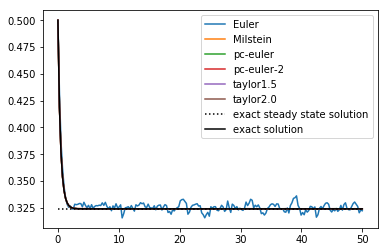

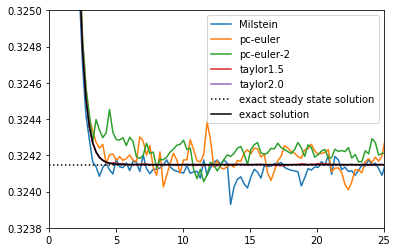

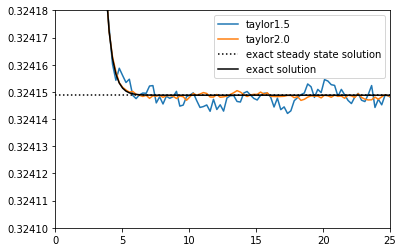

In [12]:
plot(tlist,sol_euler.expect[1] - abs(sol_euler.expect[0])**2, label='Euler')
plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2, label='Milstein')
plot(tlist,sol_pc_euler.expect[1] - abs(sol_pc_euler.expect[0])**2, label='pc-euler')
plot(tlist,sol_pc_euler2.expect[1] - abs(sol_pc_euler2.expect[0])**2, label='pc-euler-2')
plot(tlist,sol_taylor15.expect[1] - abs(sol_taylor15.expect[0])**2, label='taylor1.5')
plot(tlist,sol_taylor20.expect[1] - abs(sol_taylor20.expect[0])**2, label='taylor2.0')
plot(tlist,Vc*ones(NN),"k:", label='exact steady state solution')
plot(tlist,y,"k", label="exact solution")
legend();
show()

#plot(tlist,sol_euler.expect[1] - abs(sol_euler.expect[0])**2, label='Euler')
plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2, label='Milstein')
plot(tlist,sol_pc_euler.expect[1] - abs(sol_pc_euler.expect[0])**2, label='pc-euler')
plot(tlist,sol_pc_euler2.expect[1] - abs(sol_pc_euler2.expect[0])**2, label='pc-euler-2')
plot(tlist,sol_taylor15.expect[1] - abs(sol_taylor15.expect[0])**2, label='taylor1.5')
plot(tlist,sol_taylor20.expect[1] - abs(sol_taylor20.expect[0])**2, label='taylor2.0')
plot(tlist,Vc*ones(NN),"k:", label='exact steady state solution')
plot(tlist,y,"k", label="exact solution")
legend();
xlim([0,25])
ylim([0.3238,0.325])
show()

#plot(tlist,sol_euler.expect[1] - abs(sol_euler.expect[0])**2, label='Euler')
#plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2, label='Milstein')
#plot(tlist,sol_pc_euler.expect[1] - abs(sol_pc_euler.expect[0])**2, label='pc-euler')
#plot(tlist,sol_pc_euler2.expect[1] - abs(sol_pc_euler2.expect[0])**2, label='pc-euler-2')
plot(tlist,sol_taylor15.expect[1] - abs(sol_taylor15.expect[0])**2, label='taylor1.5')
plot(tlist,sol_taylor20.expect[1] - abs(sol_taylor20.expect[0])**2, label='taylor2.0')
plot(tlist,Vc*ones(NN),"k:", label='exact steady state solution')
plot(tlist,y,"k", label="exact solution")
legend();
xlim([0,25])
ylim([0.3241,0.32418])
show()

# Two stochastic operators

In [13]:
th = 0.1
alpha = cos(th)
beta = sin(th)
gamma = 1
eps = 0.3

VcEps = ((1-2*eps)*alpha*beta - gamma + \
         sqrt((gamma-alpha*beta)**2 + 4*gamma*alpha*((1-eps)*alpha + eps*beta)))/(4*(1-eps)*alpha**2)
UcEps = (-(1-2*eps)*alpha*beta - gamma + \
         sqrt((gamma-alpha*beta)**2 + 4*eps*beta*gamma*(beta-alpha)))/(4*eps*beta**2)

NN = 200
tlist = linspace(0,3,NN)
Nsub = 200
N = 20
Id = qeye(N)
a = destroy(N)
s = 0.5*((alpha+beta)*a + (alpha-beta)*a.dag())
x = (a + a.dag())/sqrt(2)
H = Id
c_op = [sqrt(gamma)*a]
sc_op = [sqrt(1-eps)*s, sqrt(eps)*1j*s]
e_op = [x, x*x]
rho0 = fock_dm(N,0)
y0 = 0.5

In [14]:
def func(y, t):
    return -(gamma - (1-2*eps)*alpha*beta)*y - 2*(1-eps)*alpha*alpha*y*y + 0.5*(gamma + eps*beta*beta)
y = odeint(func, y0, tlist)

def funcZ(z, t):
    return -(gamma + (1-2*eps)*alpha*beta)*z - 2*eps*beta*beta*z*z + 0.5*(gamma + (1-eps)*alpha*alpha)
z = odeint(funcZ, y0, tlist)

In [15]:
# Euler-Maruyama
sol_euler = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='euler-maruyama',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   4.87s


In [16]:
# Milstein
sol_mil = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='milstein',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:   7.97s


In [17]:
# predictor-corrector
sol_pc_euler = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='pc-euler',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:  16.41s


In [18]:
# predictor-corrector-2
sol_pc_euler2 = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='pred-corr-2',
                   options=Odeoptions(store_states=True, average_states=False))

Total run time:  18.74s


In [ ]:
# Default: taylor1.5
sol_taylor15 = smesolve(H, rho0, tlist, c_op, sc_op, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='taylor1.5',
                   options=Odeoptions(store_states=True, average_states=False))

## Variance $V_{\mathrm{c}}$ as a function of time

In [ ]:
plot(tlist,sol_euler.expect[1] - abs(sol_euler.expect[0])**2, label='Euler')
plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2, label='Milstein')
plot(tlist,sol_pc_euler.expect[1] - abs(sol_pc_euler.expect[0])**2, label='pc-euler')
plot(tlist,sol_pc_euler2.expect[1] - abs(sol_pc_euler2.expect[0])**2, label='pc-euler-2')
plot(tlist,sol_taylor15.expect[1] - abs(sol_taylor15.expect[0])**2, label='taylor1.5')
plot(tlist,Vc*ones(NN), label='exact steady state solution')
plot(tlist,y, label="exact solution")
legend();
show()

plot(tlist,sol_euler.expect[1] - abs(sol_euler.expect[0])**2, label='Euler')
plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2, label='Milstein')
plot(tlist,sol_pc_euler.expect[1] - abs(sol_pc_euler.expect[0])**2, label='pc-euler')
plot(tlist,sol_pc_euler2.expect[1] - abs(sol_pc_euler2.expect[0])**2, label='pc-euler-2')
plot(tlist,sol_taylor15.expect[1] - abs(sol_taylor15.expect[0])**2, label='taylor1.5')
plot(tlist,Vc*ones(NN), label='exact steady state solution')
plot(tlist,y, label="exact solution")
legend();
xlim([1.5,3.0])
ylim([0.347,0.356])

In [ ]:
plot(tlist,sol_euler.expect[1] - abs(sol_euler.expect[0])**2-y.transpose()[0], label='Euler')
plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2-y.transpose()[0], label='Milstein')
plot(tlist,sol_pc_euler.expect[1] - abs(sol_pc_euler.expect[0])**2-y.transpose()[0], label='pc-euler')
plot(tlist,sol_pc_euler2.expect[1] - abs(sol_pc_euler2.expect[0])**2-y.transpose()[0], label='pc-euler-2')
plot(tlist,sol_taylor15.expect[1] - abs(sol_taylor15.expect[0])**2-y.transpose()[0], label='taylor1.5')
legend()
show()

plot(tlist,sol_mil.expect[1] - abs(sol_mil.expect[0])**2-y.transpose()[0], label='Milstein')
plot(tlist,sol_pc_euler.expect[1] - abs(sol_pc_euler.expect[0])**2-y.transpose()[0], label='pc-euler')
plot(tlist,sol_pc_euler2.expect[1] - abs(sol_pc_euler2.expect[0])**2-y.transpose()[0], label='pc-euler-2')
plot(tlist,sol_taylor15.expect[1] - abs(sol_taylor15.expect[0])**2-y.transpose()[0], label='taylor1.5')
legend()
show()

#Multiple stochastic operators

In [ ]:
sc_ops_multiple = [sc_op[0]*0.5**0.5, sc_op[0]*0.5**0.5]
#Euler-Maruyama
sol_eul = smesolve(H, rho0, tlist, c_op, sc_ops_multiple, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='euler',
                   options=Odeoptions(store_states=True, average_states=False))

In [ ]:
#Milstein
sol_milstein = smesolve(H, rho0, tlist, c_op, sc_ops_multiple, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='milstein',
                   options=Odeoptions(store_states=True, average_states=False))

In [ ]:
#taylor1.5
sol_taylor = smesolve(H, rho0, tlist, c_op, sc_ops_multiple, e_op,
                   nsubsteps=Nsub, method='homodyne', solver='taylor1.5',
                   options=Odeoptions(store_states=True, average_states=False))

In [ ]:
plot(tlist,sol_eul.expect[1] - abs(sol_eul.expect[0])**2, label='Euler')
plot(tlist,sol_milstein.expect[1] - abs(sol_milstein.expect[0])**2, label='Milstein')
plot(tlist,sol_taylor.expect[1] - abs(sol_taylor.expect[0])**2, label='taylor1.5')
plot(tlist,Vc*ones(NN), label='exact steady state solution')
plot(tlist,y, label="exact solution")
legend()
show()

### Software versions

In [ ]:
from qutip.ipynbtools import version_table

version_table()